# Лабораторная работа № 4
**Вариант:** 9

In [1]:
import numpy as np
from numpy import sin, cos, pi
from tensorflow import keras
from keras import backend
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap

In [2]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'pdf')
plt.rcParams['figure.dpi'] = 100

In [3]:
def plot_history(h, *metrics):
    for metric in metrics:
        print(f"{metric}: {h.history[metric][-1]:.4f}")
    figure = plt.figure(figsize=(5.5 * len(metrics), 3.5))
    for i, metric in enumerate(metrics, 1):
        ax = figure.add_subplot(1, len(metrics), i)
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.title(metric)
        plt.plot(h.history[metric], '-')
    plt.show()

In [4]:
class RBFLayer(keras.layers.Layer):
    def __init__(self, output_dim, mu_init='uniform', sigma_init='random_normal', **kwargs):
        self.output_dim = output_dim
        self.mu_init = mu_init
        self.sigma_init = sigma_init
        super(RBFLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.mu = self.add_weight(name='mu', shape=(input_shape[1], self.output_dim), initializer=self.mu_init, trainable=True)
        self.sigma = self.add_weight(name='sigma', shape=(self.output_dim,), initializer=self.sigma_init, trainable=True)
        super(RBFLayer, self).build(input_shape)
        
    def call(self, inputs):
        diff = backend.expand_dims(inputs) - self.mu
        output = backend.exp(backend.sum(diff ** 2, axis=1) * self.sigma)
        return output

## Классификация

In [5]:
def ellipse(t, a, b, x0, y0, alpha):
    x = a * cos(t)
    y = b * sin(t)
    x, y = rotate(x, y, alpha)
    return np.array((x + x0, y + y0)).T

def rotate(x, y, alpha):
    xr = x * cos(alpha) - y * sin(alpha)
    yr = x * sin(alpha) + y * cos(alpha)
    return xr, yr

In [6]:
def plot_three_classes(data, labels, colors):
    plt.scatter(data1[:, 0], data1[:, 1], c=[colors[i[1]+i[2]*2] for i in labels1], marker='.')
COLORS = ['red', 'green', 'blue']

In [7]:
a1 = 0.2; b1 = 0.2; alpha1 = 0;       x01 = -0.2; y01 = 0
a2 = 0.7; b2 = 0.5; alpha2 = -pi / 3; x02 = 0;    y02 = 0
a3 = 1;   b3 = 1;   alpha3 = 0;       x03 = 0;    y03 = 0

In [8]:
t = np.arange(0, 2 * pi, 0.025)
ellipse1 = ellipse(t, a1, b1, x01, y01, alpha1)
ellipse2 = ellipse(t, a2, b2, x02, y02, alpha2)
ellipse3 = ellipse(t, a3, b3, x03, y03, alpha3)

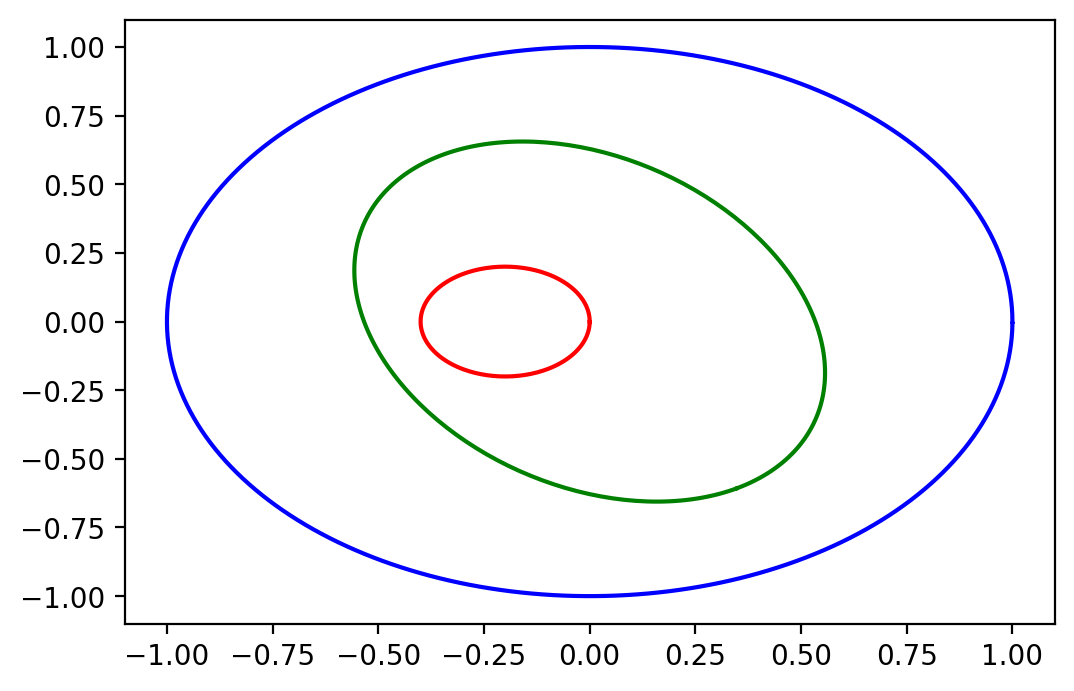

In [9]:
plt.plot(ellipse1[:, 0], ellipse1[:, 1], COLORS[0])
plt.plot(ellipse2[:, 0], ellipse2[:, 1], COLORS[1])
plt.plot(ellipse3[:, 0], ellipse3[:, 1], COLORS[2])
plt.show()

In [10]:
rng = np.random.default_rng()
data1 = np.array((*rng.choice(ellipse1, 60, False, axis=0),
                  *rng.choice(ellipse2, 100, False, axis=0),
                  *rng.choice(ellipse3, 120, False, axis=0)))
labels1 = np.array((*[[1, 0, 0] for _ in range(60)],
                    *[[0, 1, 0] for _ in range(100)],
                    *[[0, 0, 1] for _ in range(120)]))

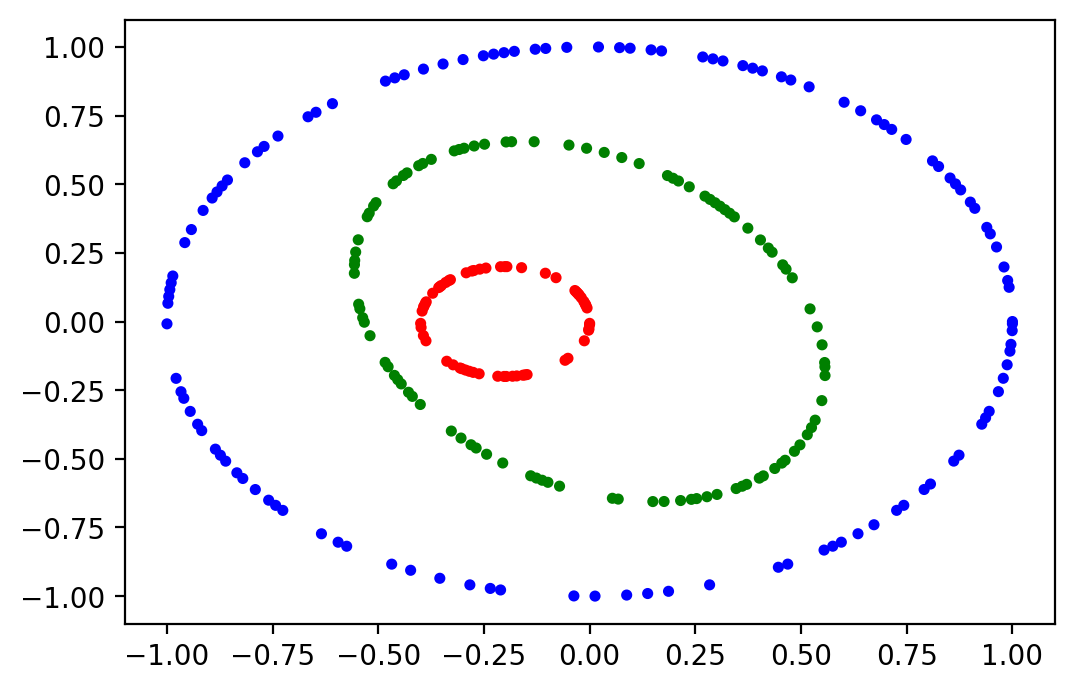

In [11]:
plot_three_classes(data1, labels1, COLORS)
plt.show()

In [12]:
train_data1, test_data1, train_labels1, test_labels1 = train_test_split(data1, labels1, train_size=0.8)

In [13]:
model1 = keras.models.Sequential([
    RBFLayer(10, input_dim=2),
    keras.layers.Dense(3, activation='sigmoid')
])
model1.compile(keras.optimizers.Adam(0.01), 'mse', ['accuracy'])

hist1 = model1.fit(train_data1, train_labels1, validation_data=(test_data1, test_labels1), batch_size=20, epochs=70, verbose=0)

loss: 0.0076


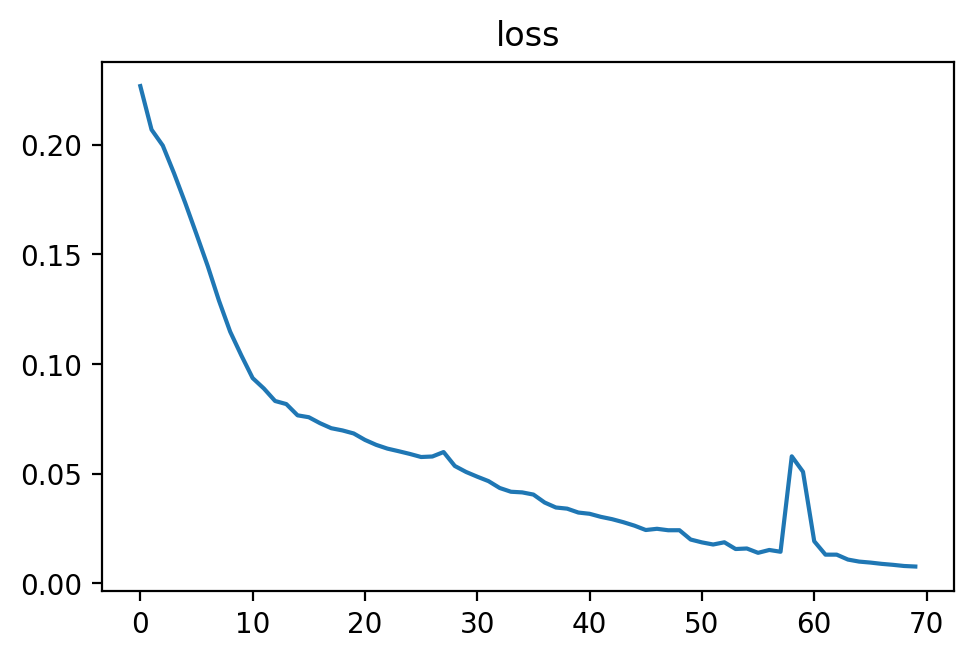

accuracy: 1.0000
val_accuracy: 1.0000


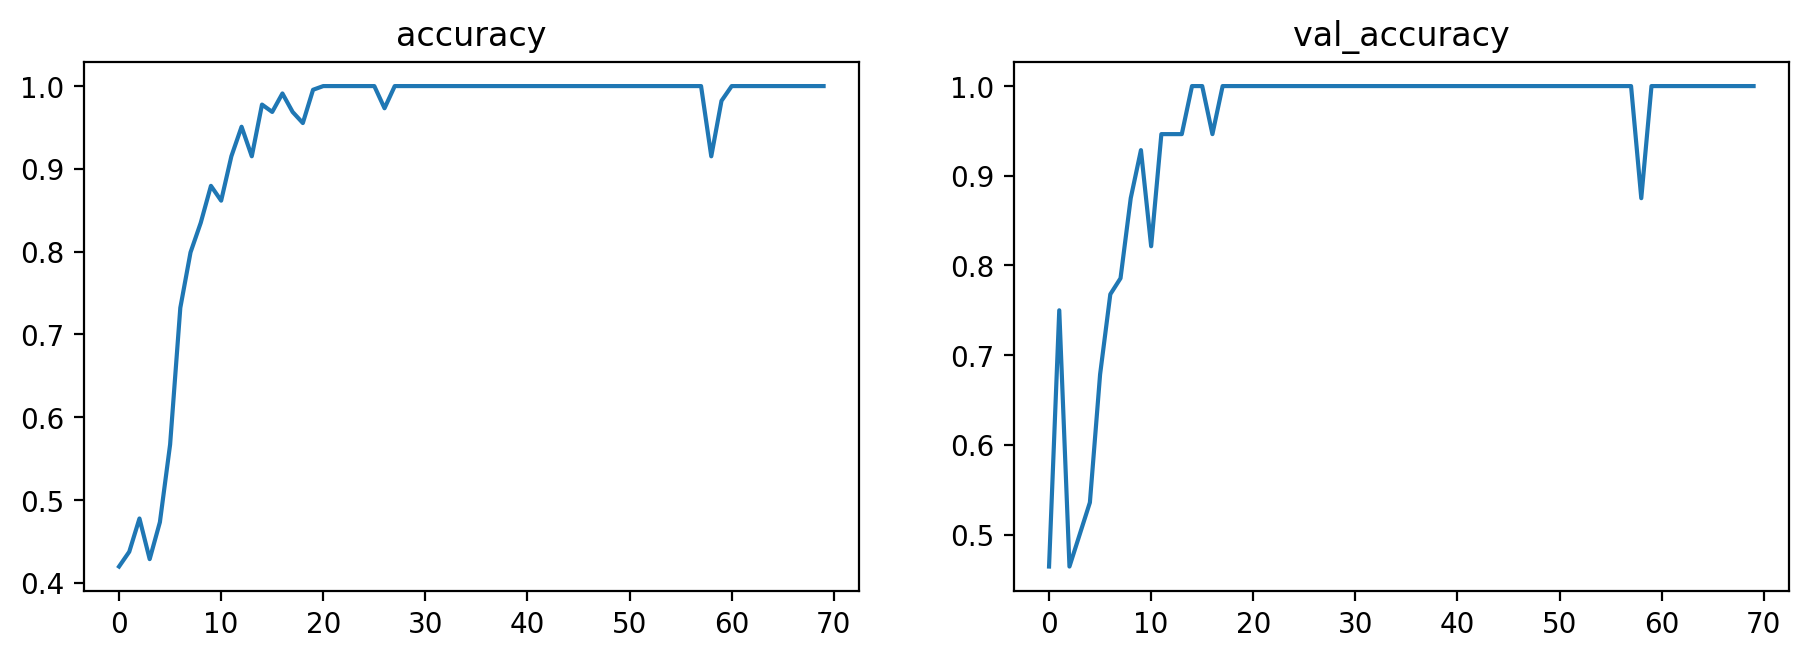

In [14]:
plot_history(hist1, 'loss')
plot_history(hist1, 'accuracy', 'val_accuracy')

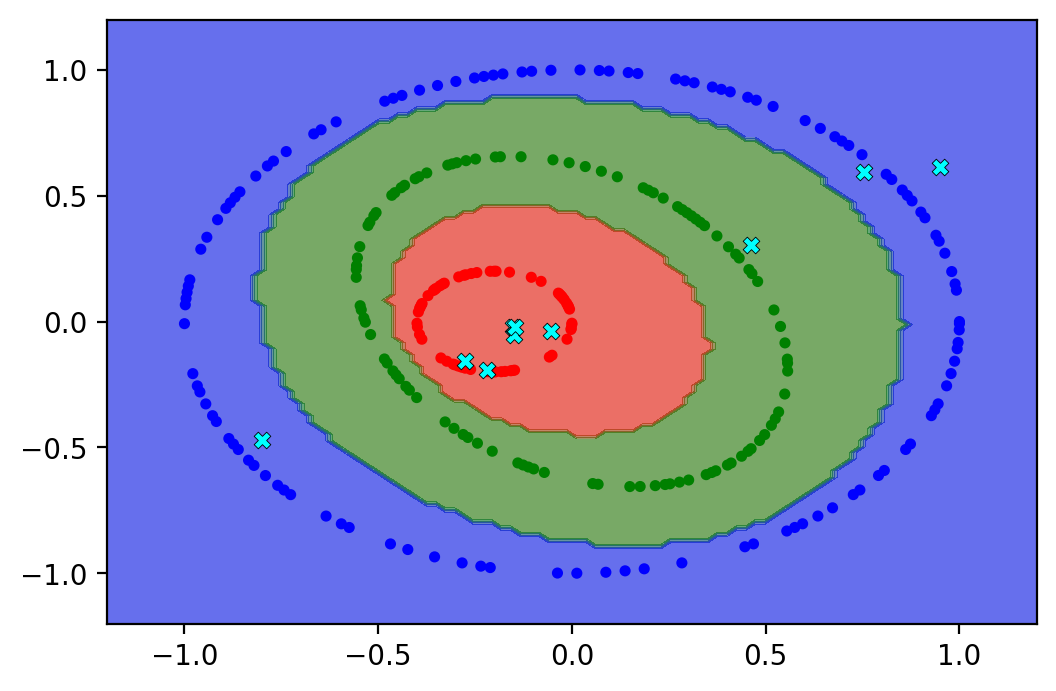

In [15]:
n = 100
x = np.linspace(-1.2, 1.2, n)
y = np.linspace(-1.2, 1.2, n)

xv, yv = np.meshgrid(x, y)
z = model1.predict(np.c_[xv.ravel(), yv.ravel()]).argmax(axis=1).reshape(n, n)

cmap = LinearSegmentedColormap.from_list('cmap', COLORS)
plt.contourf(xv, yv, z, alpha = 0.6, cmap=cmap)
plot_three_classes(train_data1, train_labels1, COLORS)
mu = model1.get_layer(index=0).get_weights()[0]
plt.scatter(mu[0], mu[1], marker='X', color='cyan', edgecolors='black', lw=0.3)
plt.show()

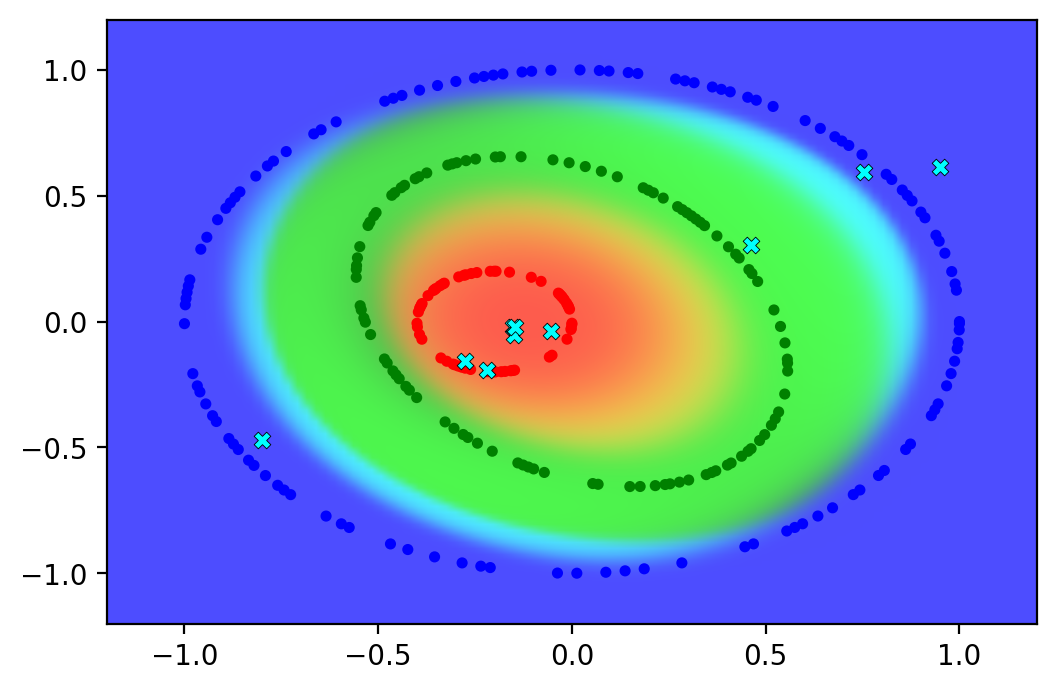

In [24]:
n = 100
x = np.linspace(-1.2, 1.2, n)
y = np.linspace(-1.2, 1.2, n)

xv, yv = np.meshgrid(x, y)
z = model1.predict(np.c_[xv.ravel(), yv.ravel()]).reshape(n, n, 3)

plt.imshow(z, extent=(-1.2, 1.2, -1.2, 1.2), alpha=0.7, origin='lower', aspect='auto', interpolation='bilinear')
plot_three_classes(test_data1, test_labels1, COLORS)
mu = model1.get_layer(index=0).get_weights()[0]
plt.scatter(mu[0], mu[1], marker='X', color='cyan', edgecolors='black', lw=0.3)
plt.show()

## Аппроксимация

In [17]:
def f(t):
    return sin(t ** 2 - 2 * t + 5)

In [18]:
h = 0.025
train_data2 = np.arange(0, 5, h)
train_labels2 = f(train_data2)

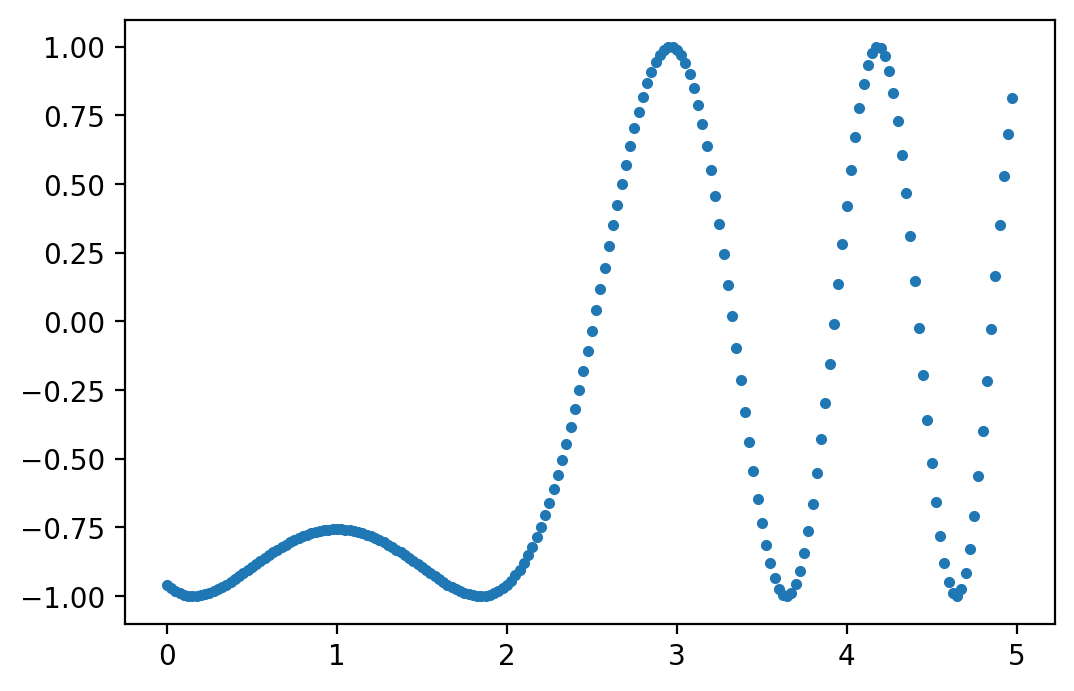

In [19]:
plt.plot(train_data2, train_labels2, '.')
plt.show()

In [49]:
model2 = keras.models.Sequential([
    RBFLayer(24, input_dim=1, mu_init=keras.initializers.RandomUniform(minval = 0, maxval = 5)),
    keras.layers.Dense(24, activation='tanh'),
    keras.layers.Dense(1, activation='linear')
])
model2.compile(keras.optimizers.Adam(0.001), 'mse', ['mae'])

hist2 = model2.fit(train_data2, train_labels2, batch_size=5, epochs=1000, verbose=0, shuffle=True)

loss: 0.0009
mae: 0.0208


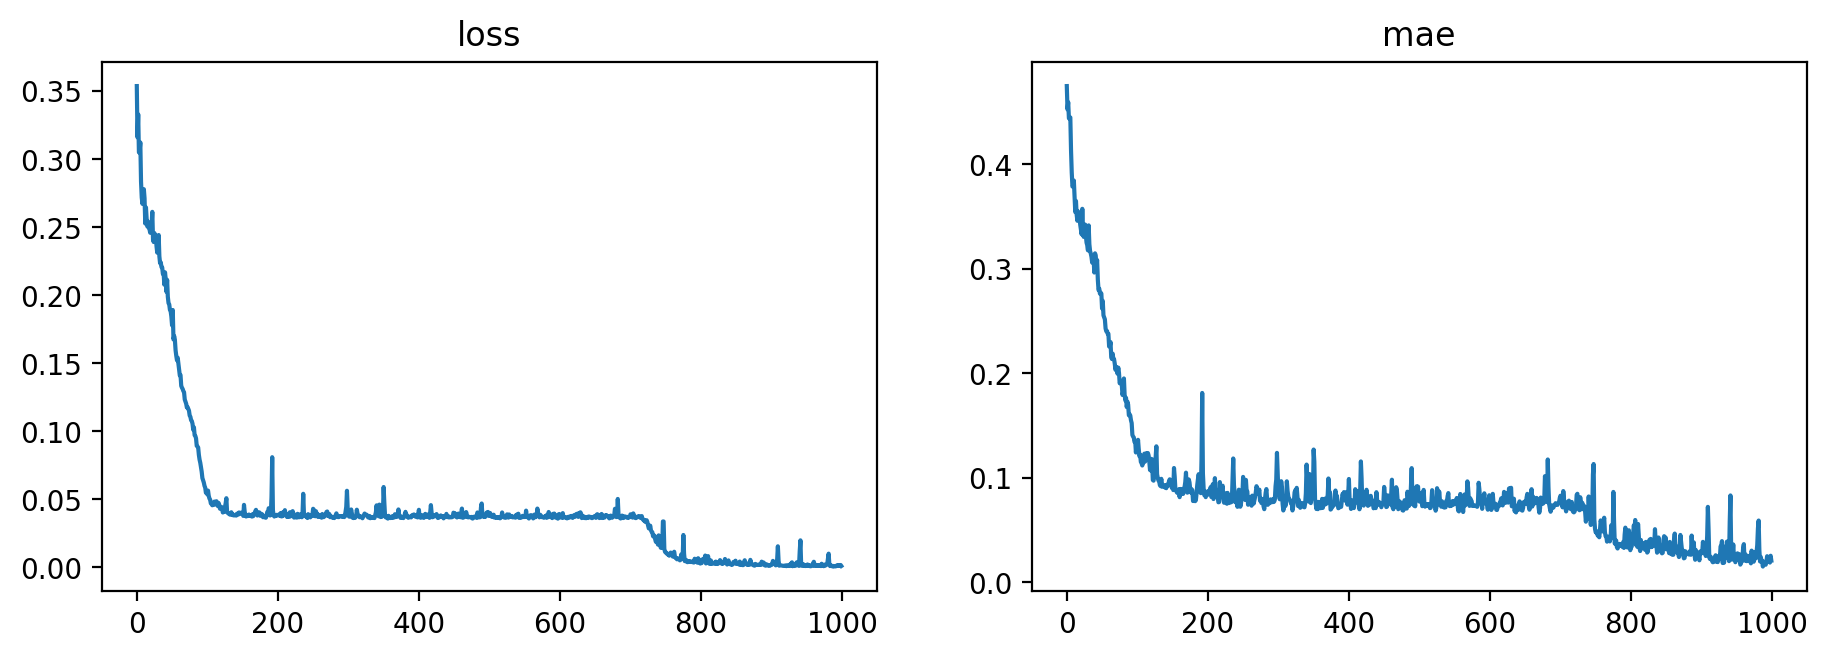

In [50]:
plot_history(hist2, 'loss', 'mae')

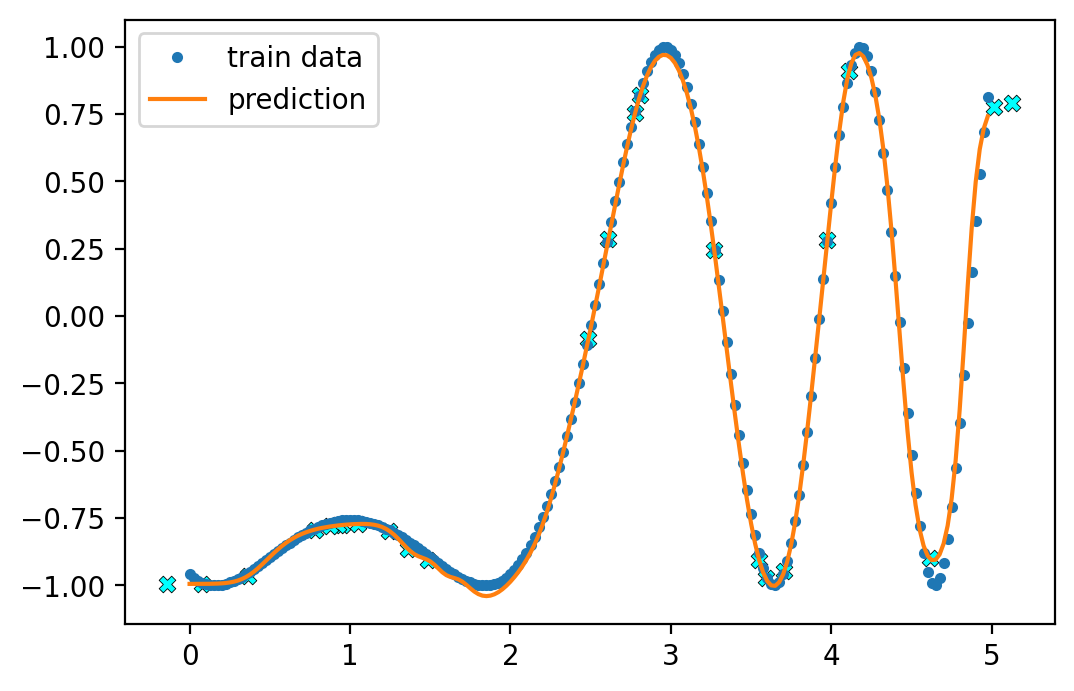

In [51]:
plt.plot(train_data2, train_labels2, '.', label='train data')
plt.plot(train_data2, model2.predict(train_data2).flat, label='prediction')
mu = model2.get_layer(index=0).get_weights()[0][0]
mu_y = model2.predict(mu)
plt.scatter(mu, mu_y.flat, marker='X', color='cyan', edgecolors='black', lw=0.3)
plt.legend()
plt.show()

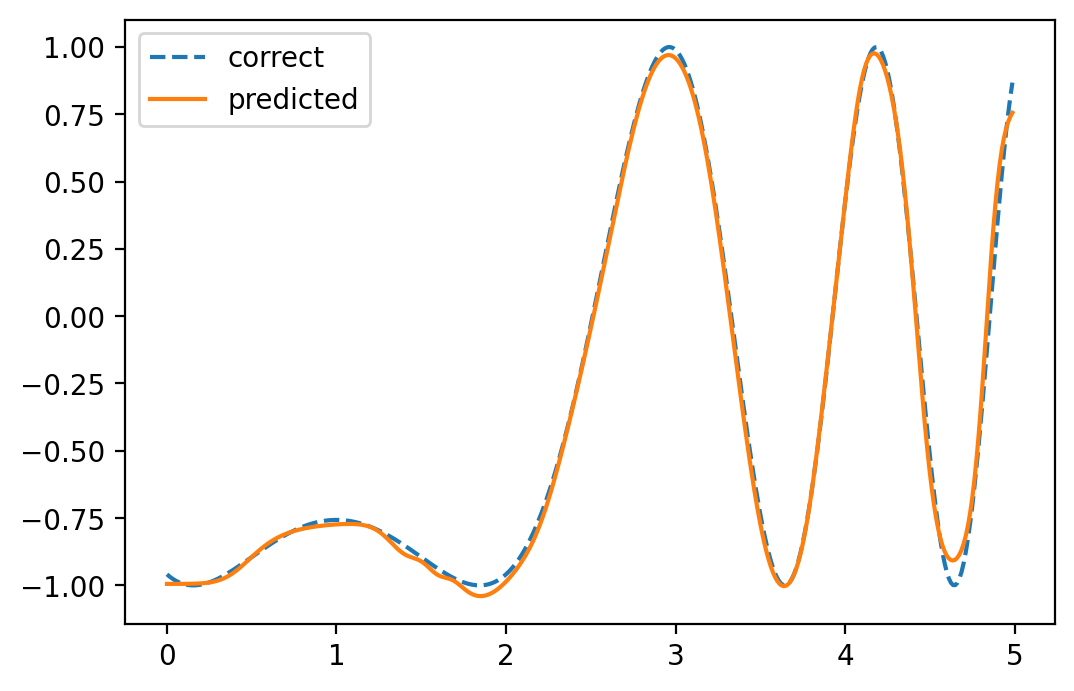

In [52]:
test_data2 = np.arange(0, 5, h / 2)
test_labels2 = f(test_data2)

plt.plot(test_data2, test_labels2, '--', label='correct')
plt.plot(test_data2, model2.predict(test_data2).flat, label='predicted')
plt.legend()
plt.show()